In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import os
import json
import re


In [3]:
MMLU_Flag = True
GPQA_Flag = False

from statsmodels.stats.contingency_tables import mcnemar
if MMLU_Flag:
  MMLU_sampales = 14042 #14079
else:
  MMLU_sampales = 546 #

# Define the directory containing the JSON files
#directory =  r'/content/drive/MyDrive/Bias mitigation/LLM/EvalMMLU/EvalMMLU/G1.0'
#directory =  r'/content/drive/MyDrive/Bias mitigation/LLM/EvalMMLU/EvalMMLU/G1.5'
#directory =  r'/content/drive/MyDrive/Bias mitigation/LLM/EvalMMLU/EvalMMLU/G0.5'

#directory =  r'/content/drive/MyDrive/Bias mitigation/LLM/EvalMMLU/EvalMMLU/M0.5'
directory =  r'/content/drive/MyDrive/Bias mitigation/LLM/EvalMMLU/EvalMMLU/M1.0'


#directory = r'/content/drive/MyDrive/Bias mitigation/LLM/EvalMMLU/EvalMMLU/1.0' #1.0
#directory = r'/content/drive/MyDrive/Bias mitigation/LLM/EvalMMLU/EvalMMLU/0.5'
#directory = r'/content/drive/MyDrive/Bias mitigation/LLM/EvalMMLU/EvalMMLU/0.1'


# Initialize a list to store the results
experiment_results = []

# Iterate over each result file in the directory
for filename in os.listdir(directory):
    if filename.startswith('results_') and filename.endswith('.json'):
        file_path = os.path.join(directory, filename)
        with open(file_path, 'r') as file:
            data = json.load(file)
            if GPQA_Flag:
              data = data["results"]
              # Rename keys in each result
              for entry in data:
                # Rename original key
                if 'original_is_correct' in entry:
                  entry['original_question_is_correct'] = entry.pop('original_is_correct')
                # Rename rephrased key
                if 'rephrased_is_correct' in entry:
                  entry['rephrased_question_is_correct'] = entry.pop('rephrased_is_correct')

            # Extract the model name from the filename
            model_name = filename.split('results_')[1].split('.json')[0]
            # Extract the number of parameters from the model name
            params_match = re.search(r'(\d+(\.\d+)?)(b|B)', model_name)
            num_params = float(params_match.group(1)) if params_match else None
            # Extract the model family from the model name
            model_family = None
            if 'gpt' in model_name.lower():
                model_family = 'Gpt'
            elif 'gemma' in model_name.lower():
                model_family = 'Gemma'
            elif 'llama' in model_name.lower():
                model_family = 'Llama'
            elif 'qwen' in model_name.lower():
                model_family = 'Qwen'
            elif 'phi' in model_name.lower():
                model_family = 'Phi'
            elif 'mistral' in model_name.lower():
                model_family = 'Mistral'
            elif 'deepseek' in model_name.lower():
                model_family = 'DeepSeek'
            elif 'yi' in model_name.lower():
                model_family = 'Yi'
            else:
                model_family = 'Other'
            # Count the number of correct answers for original and rephrased questions
            original_correct = sum(entry.get('original_question_is_correct', False) for entry in data)
            original_accuracy = original_correct/MMLU_sampales*100
            rephrased_correct = sum(entry.get('rephrased_question_is_correct', False) for entry in data)
            rephrased_accuracy = rephrased_correct/MMLU_sampales*100
            # Calculate the percentage difference
            percentage_diff = ((original_correct - rephrased_correct) / original_correct * 100)
            # Calculate the direct difference
            direct_diff = original_correct - rephrased_correct


            # Prepare data for McNemar test
            b = sum(1 for entry in data if entry.get('original_question_is_correct') and not entry.get('rephrased_question_is_correct'))
            c = sum(1 for entry in data if not entry.get('original_question_is_correct') and entry.get('rephrased_question_is_correct'))

            # McNemar test
            contingency_table = [[0, b], [c, 0]]
            mcnemar_result = mcnemar(contingency_table, exact=True)
            p_value = mcnemar_result.pvalue
            significance_ind = "Significant" if p_value < 0.05 else "Not Significant"

            if significance_ind == "Significant":
              if original_correct > rephrased_correct:
                better_performance = "Original"
              elif rephrased_correct > original_correct:
                better_performance = "Rephrased"
              else:
                better_performance = "Equal"
            else:
              better_performance = "No Significant Difference"

            # Append the results to the list
            experiment_results.append({
                'Model Name': model_name,
                'Model Family': model_family,
                'Number of Params (Billion)': num_params,
                'Original Correct': original_correct,
                'Original Accuracy' : original_accuracy,
                'Rephrased Correct': rephrased_correct,
                'Rephrased Accuracy': rephrased_accuracy,
                'Direct Diff': direct_diff,
                'Percentage Diff (%)': percentage_diff,
                #'McNemar Statistic': mcnemar_result.statistic,
                'McNemar p-value': mcnemar_result.pvalue,
                'Significance Ind': significance_ind,
                'Better Performance': better_performance
            })

# Create a DataFrame to display the results as a table
results_df = pd.DataFrame(experiment_results)

results_df = results_df.sort_values(by=["Model Family", "Number of Params (Billion)"]).reset_index(drop=True)

# Display the table
results_df

,Model Name,Model Family,Number of Params (Billion),Original Correct,Original Accuracy,Rephrased Correct,Rephrased Accuracy,Direct Diff,Percentage Diff (%),McNemar p-value,Significance Ind,Better Performance
0,gpt-4o-mini,Gpt,None,10526,74.960832,10162,72.368608,364,3.458104,6.801581e-23,Significant,Original
1,gpt-4o,Gpt,None,11778,83.876941,11439,81.462755,339,2.878248,4.810455e-25,Significant,Original
2,gpt-5_nano,Gpt,None,12164,86.625837,11838,84.304230,326,2.680039,1.234035e-20,Significant,Original
3,gpt-41_nano,Gpt,None,9785,69.683806,9483,67.533115,302,3.086357,2.813125e-12,Significant,Original
4,gpt-5_mini,Gpt,None,12716,90.556901,12406,88.349238,310,2.437874,2.358781e-25,Significant,Original


In [ ]:
results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Model Name                  7 non-null      object 
 1   Model Family                7 non-null      object 
 2   Number of Params (Billion)  0 non-null      object 
 3   Original Correct            7 non-null      int64  
 4   Original Accuracy           7 non-null      float64
 5   Rephrased Correct           7 non-null      int64  
 6   Rephrased Accuracy          7 non-null      float64
 7   Direct Diff                 7 non-null      int64  
 8   Percentage Diff (%)         7 non-null      float64
 9   McNemar p-value             7 non-null      float64
 10  Significance Ind            7 non-null      object 
 11  Better Performance          7 non-null      object 
dtypes: float64(4), int64(3), object(5)
memory usage: 804.0+ bytes


In [ ]:
results_df["Percentage Diff (%)"].mean()

np.float64(2.467398548001378)

In [ ]:
results_df.loc[results_df["Significance Ind"] == "Significant", "Percentage Diff (%)"].mean()


np.float64(2.554105425706158)

In [ ]:
(results_df["Significance Ind"] == "Significant").sum()

np.int64(18)

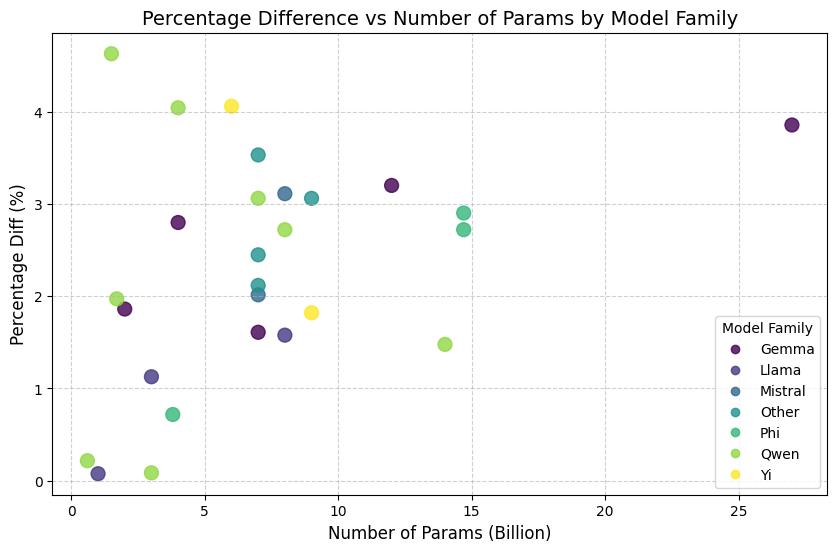

In [ ]:
import matplotlib.pyplot as plt

# Scatter plot with circular bullets
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    results_df["Number of Params (Billion)"],
    results_df["Percentage Diff (%)"],
    c=pd.factorize(results_df["Model Family"])[0],  # Convert family names to numerical values for coloring
    cmap="viridis",
    s=100,  # Size of the scatter points
    alpha=0.8,  # Transparency
    marker='o'  # Circular marker for bullets
)

# Add legend for model families
handles, labels = scatter.legend_elements(prop="colors")
family_labels = list(pd.unique(results_df["Model Family"]))
plt.legend(handles, family_labels, title="Model Family")

# Titles and labels
plt.title("Percentage Difference vs Number of Params by Model Family", fontsize=14)
plt.xlabel("Number of Params (Billion)", fontsize=12)
plt.ylabel("Percentage Diff (%)", fontsize=12)

# Show grid and plot
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


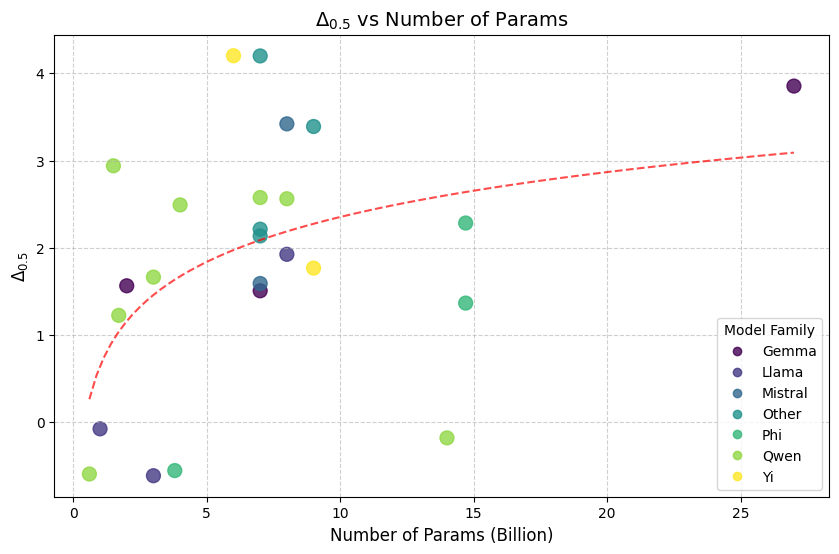

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Scatter plot with circular bullets
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    results_df["Number of Params (Billion)"],
    results_df["Percentage Diff (%)"],
    c=pd.factorize(results_df["Model Family"])[0],  # Convert family names to numerical values for coloring
    cmap="viridis",
    s=100,  # Size of the scatter points
    alpha=0.8,  # Transparency
    marker='o'  # Circular marker for bullets
)

# Add legend for model families
handles, labels = scatter.legend_elements(prop="colors")
family_labels = list(pd.unique(results_df["Model Family"]))
plt.legend(handles, family_labels, title="Model Family")

# Fit a logarithmic trend line (y = m * ln(x) + b)
x = results_df["Number of Params (Billion)"]
y = results_df["Percentage Diff (%)"]

if len(x) > 1:
    # Compute the natural log of x and fit the line
    m, b = np.polyfit(np.log(x), y, 1)

    # Generate 100 evenly spaced x values within the range of x
    x_range = np.linspace(x.min(), x.max(), 100)
    # Compute the corresponding y values for the fitted line
    y_fit = m * np.log(x_range) + b

    # Plot the logarithmic trend line
    plt.plot(x_range, y_fit, color='red', linestyle='--', alpha=0.7, label='Log Fit')

# Titles and labels
plt.title(r"$\Delta_{0.5}$ vs Number of Params", fontsize=14)
plt.xlabel("Number of Params (Billion)", fontsize=12)
plt.ylabel(r"$\Delta_{0.5}$"  , fontsize=12)

# Show grid and plot
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


Logarithmic Fit Coefficients: Slope = 0.7433, Intercept = 0.6406


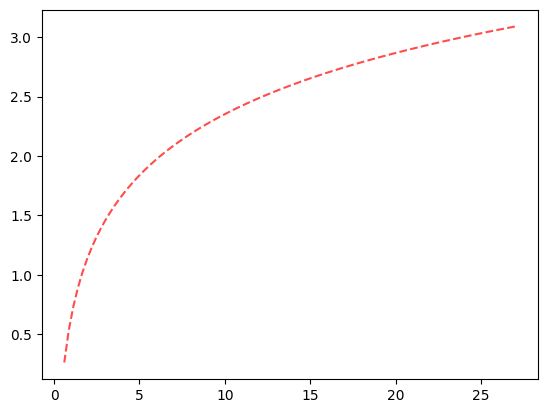

In [ ]:
# Fit a logarithmic trend line (y = m * ln(x) + b)
x = results_df["Number of Params (Billion)"]
y = results_df["Percentage Diff (%)"]

if len(x) > 1:
    # Compute the natural log of x and fit the line
    m, b = np.polyfit(np.log(x), y, 1)

    # Print the coefficients
    print(f"Logarithmic Fit Coefficients: Slope = {m:.4f}, Intercept = {b:.4f}")

    # Generate 100 evenly spaced x values within the range of x
    x_range = np.linspace(x.min(), x.max(), 100)
    # Compute the corresponding y values for the fitted line
    y_fit = m * np.log(x_range) + b

    # Plot the logarithmic trend line
    plt.plot(x_range, y_fit, color='red', linestyle='--', alpha=0.7, label='Log Fit')


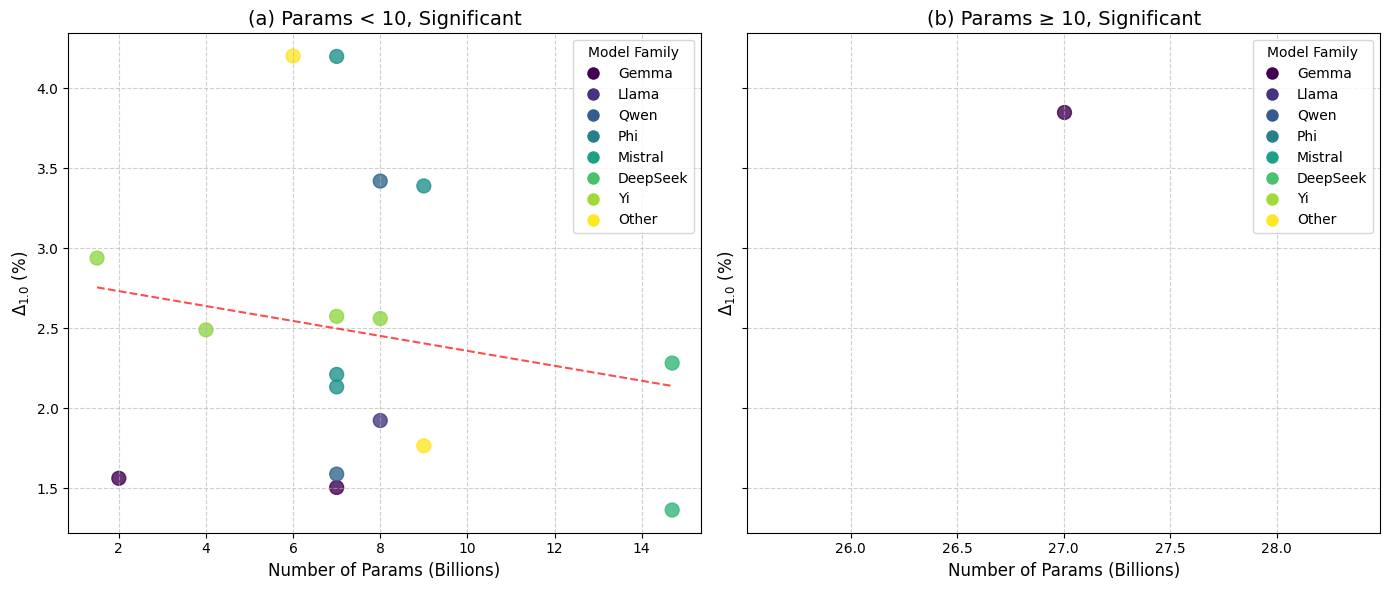

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Define the static model family labels (8 values, including 'Other')
static_family_labels = ['Gemma', 'Llama', 'Qwen', 'Phi', 'Mistral', 'DeepSeek', 'Yi', 'Other']

# Create a list of 8 equally spaced colors from the 'viridis' colormap
cmap = plt.get_cmap('viridis')
colors = [cmap(i / 7) for i in range(8)]

# Create static legend handles using Line2D
legend_handles = [
    Line2D([0], [0], marker='o', color='w', label=static_family_labels[i],
           markerfacecolor=colors[i], markersize=10)
    for i in range(8)
]

# 1) Filter DataFrames for models with params < 10 and >= 10 (only significant ones)
df_under_10 = results_df[
    (results_df["Number of Params (Billion)"] < 20) &
    (results_df["Significance Ind"] == "Significant")
]
df_over_10 = results_df[
    (results_df["Number of Params (Billion)"] >= 20) &
    (results_df["Significance Ind"] == "Significant")
]

# 2) Create subplots side by side
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 6), sharey=True)

### --- LEFT PLOT (Params < 10) ---
x_under = df_under_10["Number of Params (Billion)"]
y_under = df_under_10["Percentage Diff (%)"]

# Create a scatter plot for the left subplot
scatter1 = ax1.scatter(
    x_under,
    y_under,
    c=pd.factorize(df_under_10["Model Family"])[0],  # Colors determined by factorized model families
    cmap="viridis",
    s=100,
    alpha=0.8,
    marker='o'
)

# Calculate the trend line for the left subplot using np.polyfit:
# np.polyfit returns the slope (m_under) and intercept (b_under) for a best-fit line.
if len(x_under) > 1:  # Only compute if there are at least 2 points
    m_under, b_under = np.polyfit(x_under, y_under, 1)
    # Generate 100 evenly spaced x-values within the range of x_under
    x_range_under = np.linspace(x_under.min(), x_under.max(), 100)
    # Compute corresponding y-values using the equation: y = m * x + b
    y_fit_under = m_under * x_range_under + b_under
    # Plot the trend line on ax1
    ax1.plot(
        x_range_under,
        y_fit_under,
        color='red',
        linestyle='--',
        alpha=0.7,
        label="Trend Line"
    )

# Set the static legend using the pre-defined legend handles
ax1.legend(handles=legend_handles, title="Model Family")
ax1.set_title("(a) Params < 10, Significant", fontsize=14)
ax1.set_xlabel("Number of Params (Billions)", fontsize=12)
# Use math text for the y-axis label
ax1.set_ylabel(r"$\Delta_{1.0}$ (%)", fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.6)

### --- RIGHT PLOT (Params ≥ 10) ---
x_over = df_over_10["Number of Params (Billion)"]
y_over = df_over_10["Percentage Diff (%)"]

# Create a scatter plot for the right subplot
scatter2 = ax2.scatter(
    x_over,
    y_over,
    c=pd.factorize(df_over_10["Model Family"])[0],
    cmap="viridis",
    s=100,
    alpha=0.8,
    marker='o'
)

# Calculate the trend line for the right subplot separately:
if len(x_over) > 1:
    m_over, b_over = np.polyfit(x_over, y_over, 1)
    # Generate 100 evenly spaced x-values for this subplot
    x_range_over = np.linspace(x_over.min(), x_over.max(), 100)
    # Compute corresponding y-values using the best-fit line equation
    y_fit_over = m_over * x_range_over + b_over
    # Plot the trend line on ax2
    ax2.plot(
        x_range_over,
        y_fit_over,
        color='red',
        linestyle='--',
        alpha=0.7,
        label="Trend Line"
    )

# Set the static legend on the right subplot as well
ax2.legend(handles=legend_handles, title="Model Family")
ax2.set_title("(b) Params ≥ 10, Significant", fontsize=14)
ax2.set_xlabel("Number of Params (Billions)", fontsize=12)
# If desired, use the same math text for y-axis or omit if shared y-axis label is sufficient
ax2.set_ylabel(r"$\Delta_{1.0}$ (%)", fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.6)

# 3) Adjust layout and display the figure
plt.tight_layout()
plt.show()


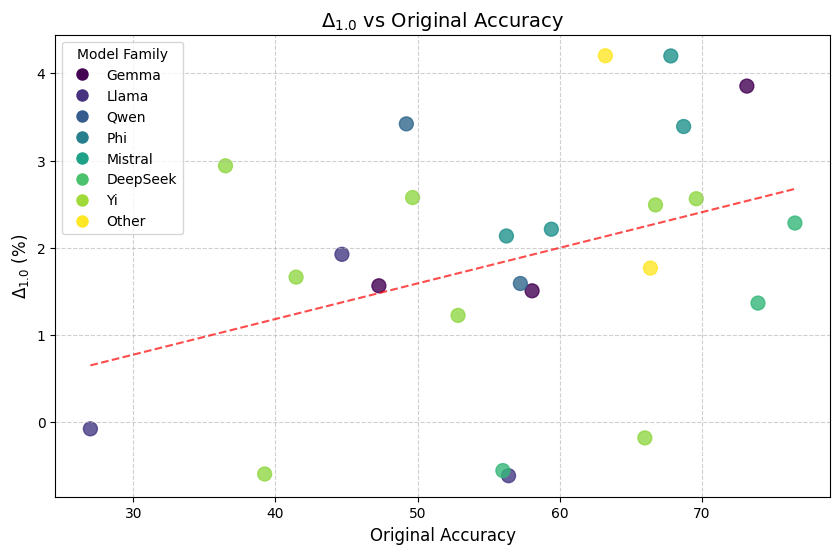

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.lines import Line2D

# Define the static model family labels (8 values, including 'Other')
static_family_labels = ['Gemma', 'Llama', 'Qwen', 'Phi', 'Mistral', 'DeepSeek', 'Yi', 'Other']

# Create a corresponding list of colors using the "viridis" colormap.
cmap = plt.get_cmap('viridis')
colors = [cmap(i / 7) for i in range(8)]  # 8 equally spaced colors

# Create legend handles for the static legend using Line2D
legend_handles = [
    Line2D([0], [0], marker='o', color='w', label=static_family_labels[i],
           markerfacecolor=colors[i], markersize=10)
    for i in range(8)
]

# Assume results_df is already defined; use it to filter data
filtered_df = results_df

# Create the scatter plot with 'Original Accuracy' on the x-axis
plt.figure(figsize=(10, 6))

scatter = plt.scatter(
    filtered_df["Original Accuracy"],
    filtered_df["Percentage Diff (%)"],
    c=pd.factorize(filtered_df["Model Family"])[0],  # Convert family names to numerical for coloring
    cmap="viridis",
    s=100,
    alpha=0.8,
    marker='o'
)

# Add a trend line if there are at least 2 data points
if len(filtered_df) > 1:
    x = filtered_df["Original Accuracy"]
    y = filtered_df["Percentage Diff (%)"]

    # Fit a simple linear regression (degree 1 polynomial)
    m, b = np.polyfit(x, y, 1)

    # Generate 100 evenly spaced x-values over the range of x
    x_range = np.linspace(x.min(), x.max(), 100)
    # Compute corresponding y-values using the linear equation: y = m*x + b
    y_fit = m * x_range + b

    # Plot the trend line without a label so that it doesn't add an extra legend entry
    plt.plot(
        x_range,
        y_fit,
        color='red',
        linestyle='--',
        alpha=0.7
    )

# Replace the automatically generated legend with the static one
plt.legend(handles=legend_handles, title="Model Family")

# Titles and labels: use math text for both the title and the y-axis label
plt.title(r"$\Delta_{1.0}$ vs Original Accuracy", fontsize=14)
plt.xlabel("Original Accuracy", fontsize=12)
plt.ylabel(r"$\Delta_{1.0}$ (%)", fontsize=12)

plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


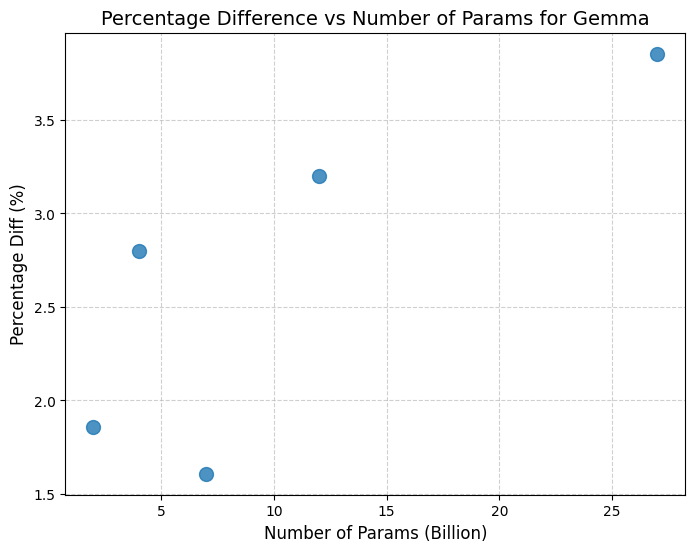

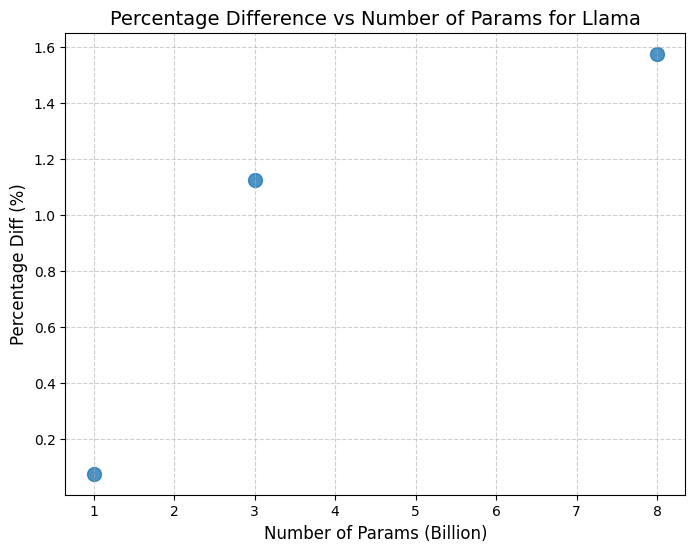

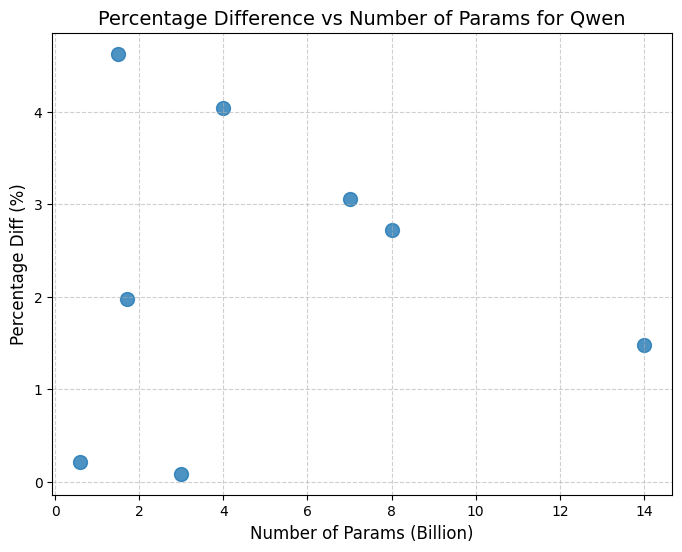

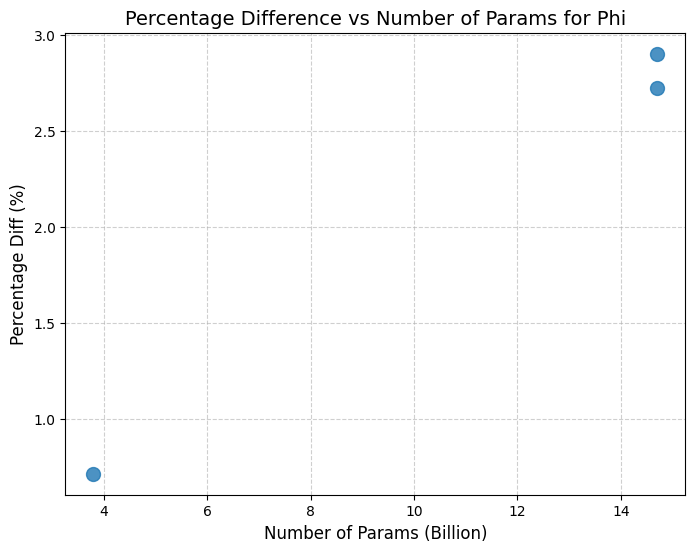

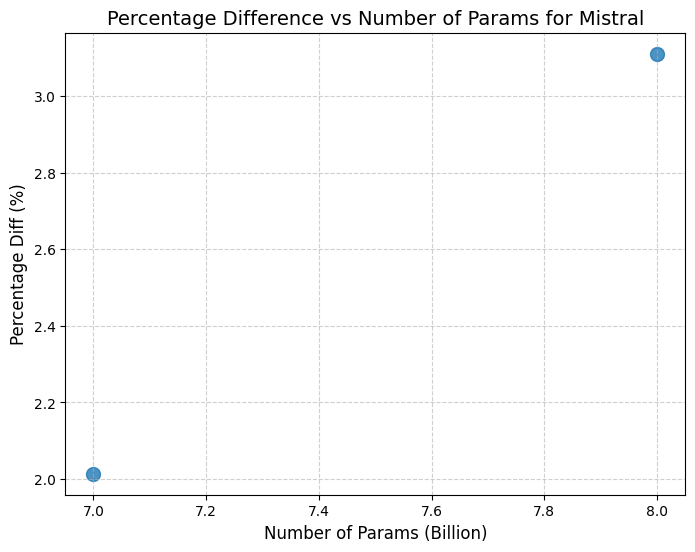

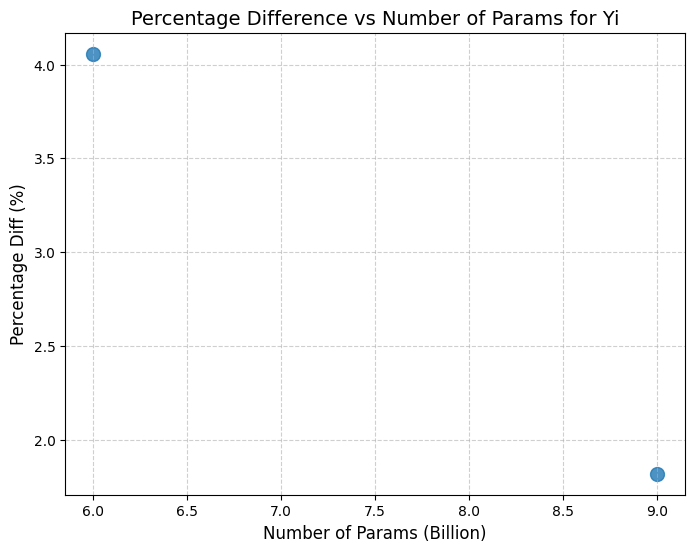

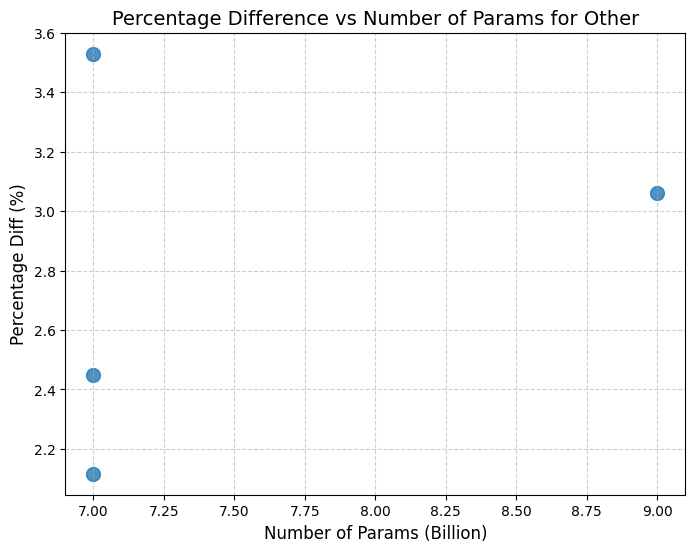

In [ ]:


# Static family labels
static_family_labels = ['Gemma', 'Llama', 'Qwen', 'Phi', 'Mistral', 'DeepSeek', 'Yi', 'Other']

# Create a scatter plot for each family
for family in static_family_labels:
    # Filter the actual data for the current family
    family_df = results_df[results_df["Model Family"] == family]

    # Only plot if there is data for this family
    if not family_df.empty:
        plt.figure(figsize=(8, 6))
        plt.scatter(
            family_df["Number of Params (Billion)"],
            family_df["Percentage Diff (%)"],
            s=100,  # Size of the scatter points
            alpha=0.8,  # Transparency
            marker='o'  # Circular marker for bullets
        )

        # Titles and labels
        plt.title(f"Percentage Difference vs Number of Params for {family}", fontsize=14)
        plt.xlabel("Number of Params (Billion)", fontsize=12)
        plt.ylabel("Percentage Diff (%)", fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()


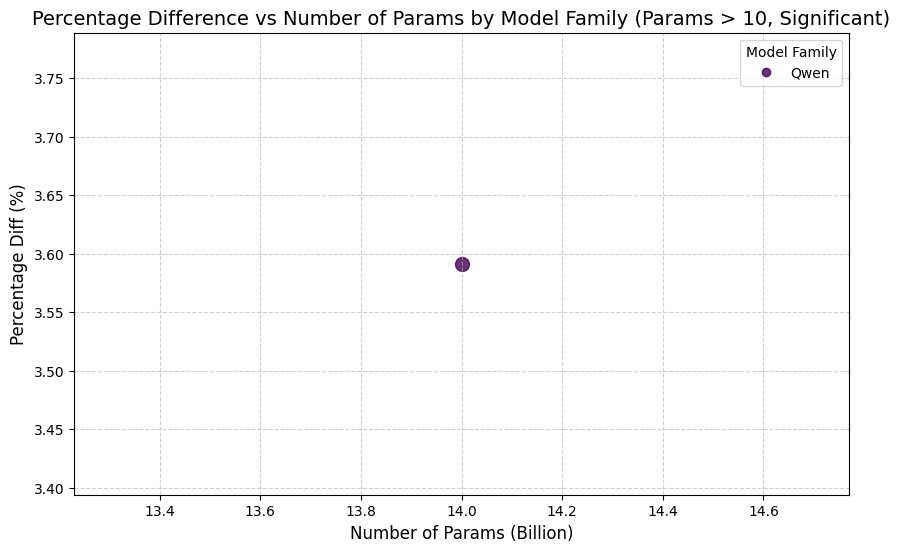

In [ ]:
# Filter the DataFrame for the desired conditions: params < 35 and significance is true
filtered_df = results_df[(results_df["Number of Params (Billion)"] > 10) & (results_df["Significance Ind"] == "Significant")]

# Scatter plot with circular bullets for the filtered data
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    filtered_df["Number of Params (Billion)"],
    filtered_df["Percentage Diff (%)"],
    c=pd.factorize(filtered_df["Model Family"])[0],  # Convert family names to numerical values for coloring
    cmap="viridis",
    s=100,  # Size of the scatter points
    alpha=0.8,  # Transparency
    marker='o'  # Circular marker for bullets
)

# Add legend for model families
handles, labels = scatter.legend_elements(prop="colors")
family_labels = list(pd.unique(filtered_df["Model Family"]))
plt.legend(handles, family_labels, title="Model Family")

# Titles and labels
plt.title("Percentage Difference vs Number of Params by Model Family (Params > 10, Significant)", fontsize=14)
plt.xlabel("Number of Params (Billion)", fontsize=12)
plt.ylabel("Percentage Diff (%)", fontsize=12)

# Show grid and plot
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


In [ ]:



json_file_path = '/content/drive/MyDrive/Bias mitigation/LLM/EvalMMLU/EvalMMLU/results_Qwen_Qwen2.5-32B-Instruct-GPTQ-Int4.json'

def extract_disagreements_with_subject(json_file_path):
    with open(json_file_path, 'r') as f:
        data = json.load(f)

    true_to_false = []
    false_to_true = []

    for item in data:
        # original_question_is_correct == True, rephrased_question_is_correct == False
        if item['original_question_is_correct'] and not item['rephrased_question_is_correct']:
            true_to_false.append({
                'subject': item['subject'],
                'original': item['original_question'],
                'rephrased': item['rephrased_question']
            })
        # original_question_is_correct == False, rephrased_question_is_correct == True
        elif not item['original_question_is_correct'] and item['rephrased_question_is_correct']:
            false_to_true.append({
                'subject': item['subject'],
                'original': item['original_question'],
                'rephrased': item['rephrased_question']
            })

    return true_to_false, false_to_true


tf_list, ft_list = extract_disagreements_with_subject(json_file_path)




In [ ]:
print("=== True -> False ===")
for entry in tf_list:
    print("Subject:", entry['subject'])
    print("Original question:", entry['original'])
    print("Rephrased question:", entry['rephrased'])
    print()



=== True -> False ===
Subject: abstract_algebra
Original question: Statement 1 | Every permutation is a cycle. Statement 2 | Every cycle is a permutation.
Rephrased question: Statement 1 | Not every permutation is a cycle. Statement 2 | Every cycle is a permutation.

Subject: abstract_algebra
Original question: Statement 1 | Every free abelian group is torsion free. Statement 2 | Every finitely generated torsion-free abelian group is a free abelian group.
Rephrased question: Statement 1 | All free abelian groups are torsion-free. Statement 2 | Any finitely generated, torsion-free abelian group is a free abelian group.

Subject: abstract_algebra
Original question: Statement 1 | S_n is non-Abelian for all n >= 3. Statement 2 | If a is a permutation that is an m-cycle and b is a permutation that is an n-cycle, then |ab| = lcm(m,n).
Rephrased question: Statement 1 | S_n is non-Abelian for every n greater than or equal to 3. Statement 2 | If a is a permutation that forms an m-cycle and b is

In [ ]:
print("=== False -> True ===")
for entry in ft_list:
    print("Subject:", entry['subject'])
    print("Original question:", entry['original'])
    print("Rephrased question:", entry['rephrased'])
    print()

=== False -> True ===
Subject: abstract_algebra
Original question: Statement 1 | For finite groups G and H, |G + H| = |G||H|. (G + H is the internal direct product.) Statement 2 | If r divides m and s divides n then Z_m + Z_n has a subgroup isomorphic to Z_r + Z_s.
Rephrased question: Statement 1 | For finite groups G and H, the order of the internal direct product of G and H is equal to the product of the orders of G and H. Statement 2 | If r is a divisor of m and s is a divisor of n, then the direct product of Z_m and Z_n contains a subgroup that is isomorphic to the direct product of Z_r and Z_s.

Subject: abstract_algebra
Original question: Find all c in Z_3 such that Z_3[x]/(x^3 + x^2 + c) is a field.
Rephrased question: Determine all values of \( c \) in \( \mathbb{Z}_3 \) for which \( \mathbb{Z}_3[x]/(x^3 + x^2 + c) \) is a field.

Subject: abstract_algebra
Original question: Statement 1 | Every field is also a ring. Statement 2 | Every ring has a multiplicative identity.
Rephra

In [ ]:

from collections import defaultdict

# Create dictionaries to hold counts by subject
tf_counts_by_subject = defaultdict(int)
ft_counts_by_subject = defaultdict(int)

# Populate True->False counts
for entry in tf_list:
    tf_counts_by_subject[entry['subject']] += 1

# Populate False->True counts
for entry in ft_list:
    ft_counts_by_subject[entry['subject']] += 1

# Get a combined set of all subjects from both dictionaries
all_subjects = set(tf_counts_by_subject.keys()).union(ft_counts_by_subject.keys())

# Print table header
print(f"{'Subject':<30} {'True->False':<15} {'False->True':<15}")
print("-" * 60)

# Print counts per subject
for subject in sorted(all_subjects):
    tf_count = tf_counts_by_subject[subject]
    ft_count = ft_counts_by_subject[subject]
    print(f"{subject:<30} {tf_count:<15} {ft_count:<15}")


Subject                        True->False     False->True    
------------------------------------------------------------
abstract_algebra               6               6              
anatomy                        5               3              
astronomy                      3               4              
business_ethics                5               3              
clinical_knowledge             14              7              
college_biology                8               3              
college_chemistry              8               4              
college_computer_science       6               4              
college_mathematics            8               3              
college_medicine               13              4              
college_physics                3               3              
computer_security              3               2              
conceptual_physics             36              7              
econometrics                   6               2         

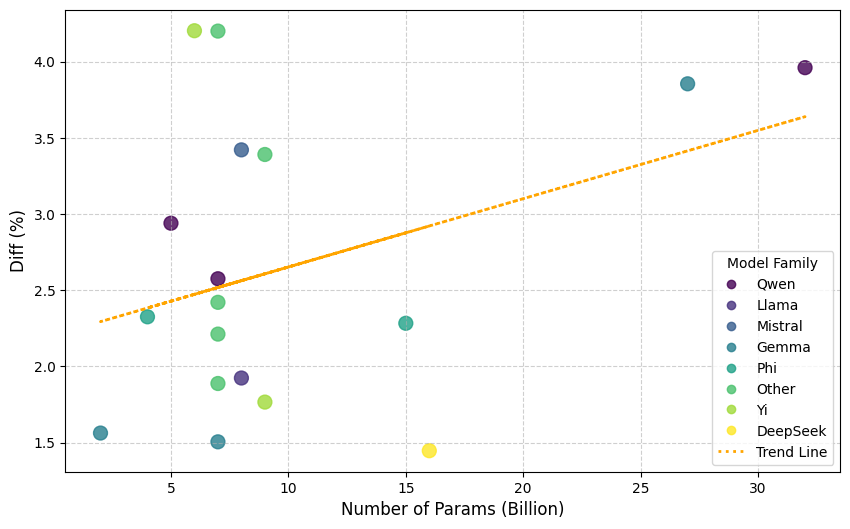

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

# Filter the DataFrame for the desired conditions: params < 35 and significance is true
filtered_df = results_df[(results_df["Number of Params (Billion)"] < 35) & (results_df["Significance Ind"] == "Significant")]

# Prepare data for the trend line
x_filtered = filtered_df["Number of Params (Billion)"].values.reshape(-1, 1)
y_filtered = filtered_df["Percentage Diff (%)"].values

# Fit a linear regression model
reg = LinearRegression()
reg.fit(x_filtered, y_filtered)
y_pred_filtered = reg.predict(x_filtered)

# Scatter plot with circular bullets for the filtered data
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    filtered_df["Number of Params (Billion)"],
    filtered_df["Percentage Diff (%)"],
    c=pd.factorize(filtered_df["Model Family"])[0],  # Convert family names to numerical values for coloring
    cmap="viridis",
    s=100,  # Size of the scatter points
    alpha=0.8,  # Transparency
    marker='o'  # Circular marker for bullets
)

# Add the trend line (dotted, orange)
plt.plot(
    filtered_df["Number of Params (Billion)"],
    y_pred_filtered,
    color='orange',
    linestyle=':',
    linewidth=2,
    label="Trend Line"
)

# Add legend for model families
handles, labels = scatter.legend_elements(prop="colors")
family_labels = list(pd.unique(filtered_df["Model Family"]))
plt.legend(handles + [plt.Line2D([0], [0], color='orange', lw=2, linestyle=':')], family_labels + ["Trend Line"], title="Model Family")

# Titles and labels
#plt.title("Percentage Difference vs Number of Params by Model Family (Params < 35, Significant)", fontsize=14)
plt.xlabel("Number of Params (Billion)", fontsize=12)
plt.ylabel("Diff (%)", fontsize=12)

# Show grid and plot
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


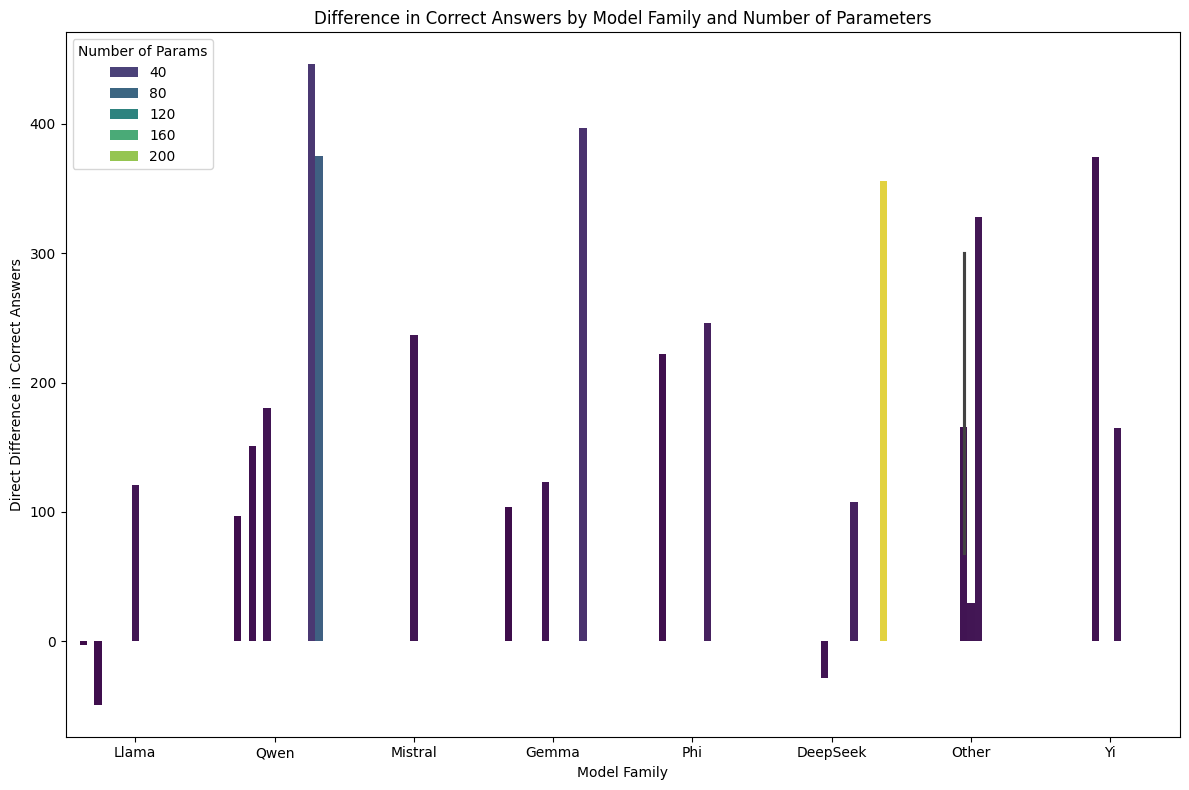

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the direct difference for each model family using a grouped bar chart
plt.figure(figsize=(12, 8))
sns.barplot(x='Model Family', y='Direct Diff', data=results_df, hue='Number of Params (Billion)', palette='viridis')
plt.title('Difference in Correct Answers by Model Family and Number of Parameters')
plt.ylabel('Direct Difference in Correct Answers')
plt.xlabel('Model Family')
plt.legend(title='Number of Params')
plt.tight_layout()
plt.show()

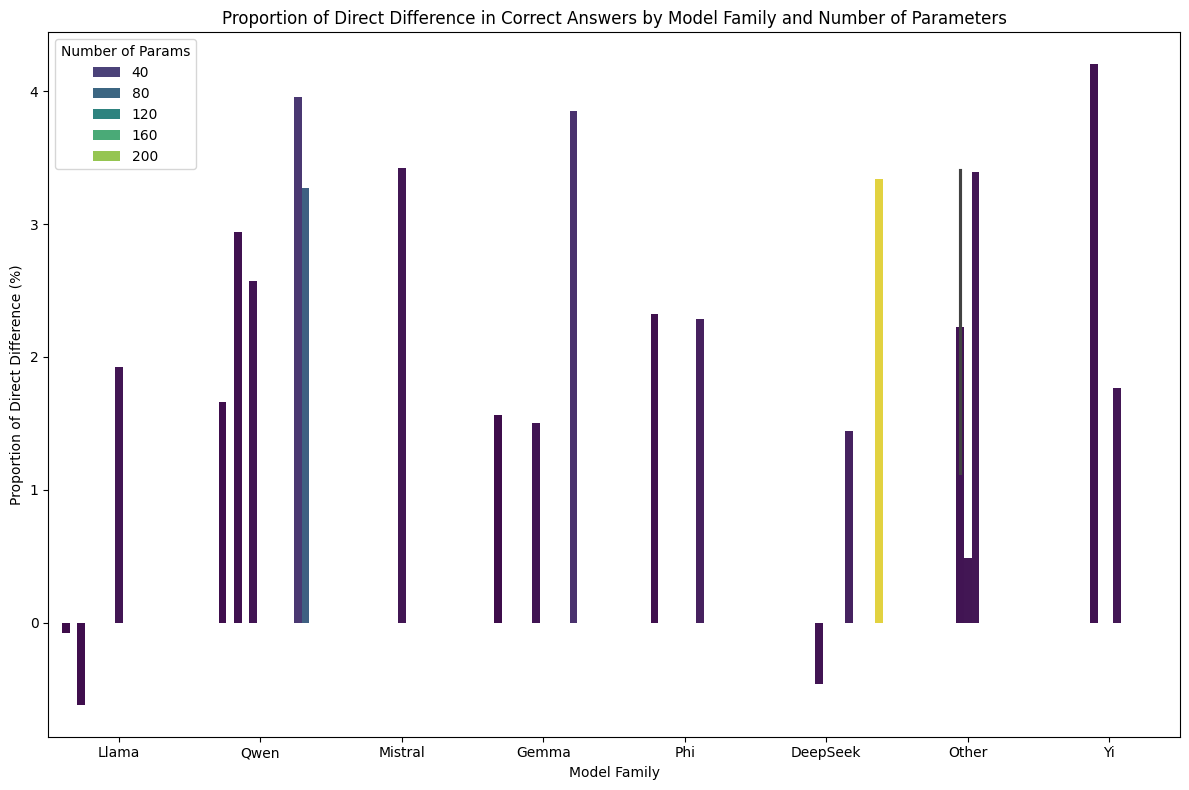

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the proportion of direct difference out of original correct answers
results_df['Proportion of Direct Diff'] = results_df['Direct Diff'] / results_df['Original Correct'] * 100

# Plot the proportion of direct difference for each model family
plt.figure(figsize=(12, 8))
sns.barplot(x='Model Family', y='Proportion of Direct Diff', data=results_df, hue='Number of Params (Billion)', palette='viridis')
plt.title('Proportion of Direct Difference in Correct Answers by Model Family and Number of Parameters')
plt.ylabel('Proportion of Direct Difference (%)')
plt.xlabel('Model Family')
plt.legend(title='Number of Params')
plt.tight_layout()
plt.show()

<Figure size 1200x800 with 0 Axes>

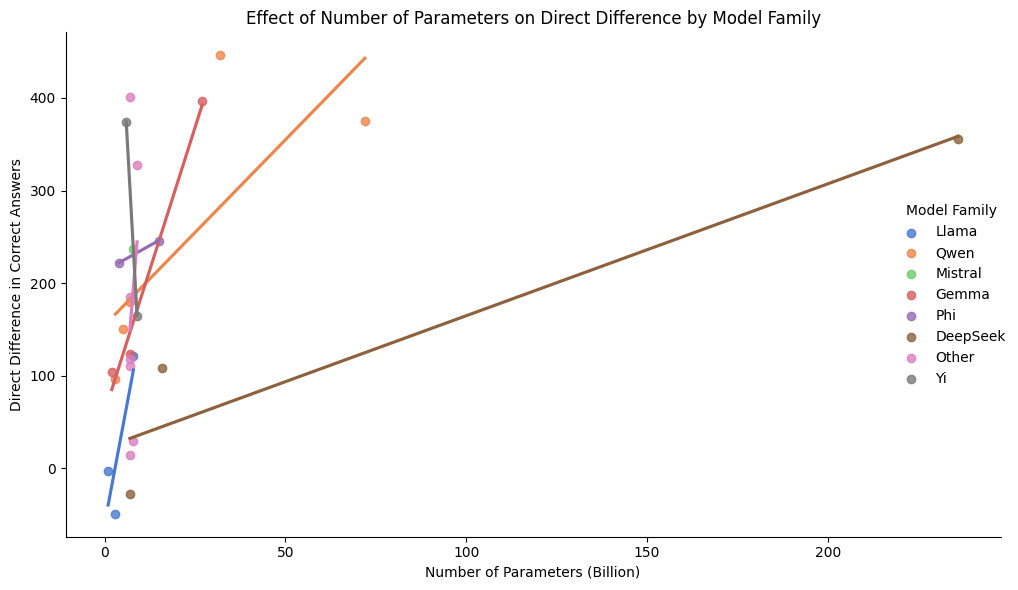

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the effect of the number of parameters on the direct difference for each model family
plt.figure(figsize=(12, 8))
sns.lmplot(x='Number of Params (Billion)', y='Direct Diff', hue='Model Family', data=results_df,
           aspect=1.5, height=6, markers='o', ci=None, palette='muted')
plt.title('Effect of Number of Parameters on Direct Difference by Model Family')
plt.xlabel('Number of Parameters (Billion)')
plt.ylabel('Direct Difference in Correct Answers')
plt.tight_layout()
plt.show()

<Figure size 1200x800 with 0 Axes>

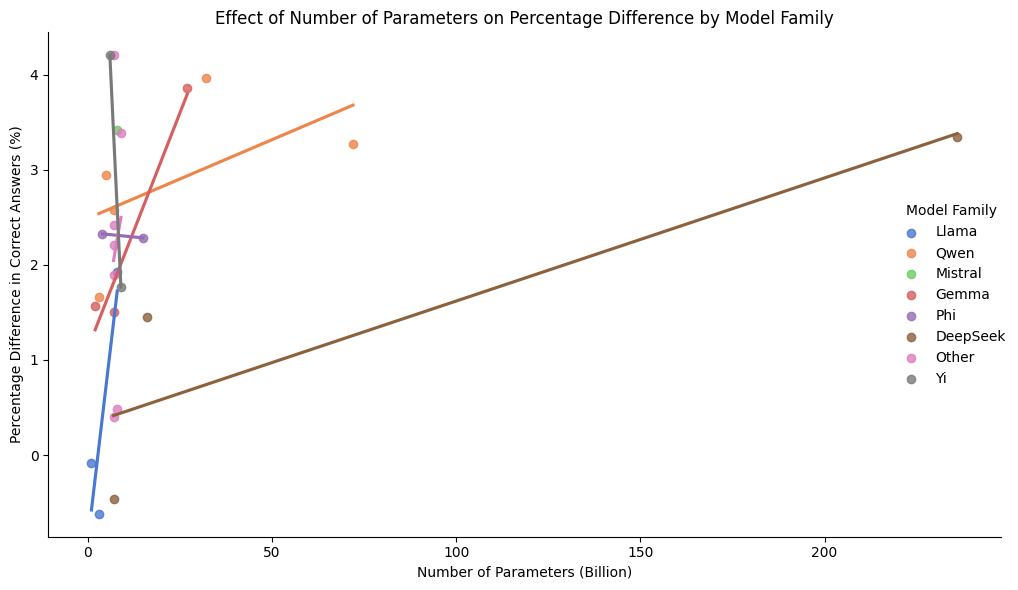

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the effect of the number of parameters on the percentage difference for each model family
plt.figure(figsize=(12, 8))
sns.lmplot(x='Number of Params (Billion)', y='Percentage Diff (%)', hue='Model Family', data=results_df,
           aspect=1.5, height=6, markers='o', ci=None, palette='muted')
plt.title('Effect of Number of Parameters on Percentage Difference by Model Family')
plt.xlabel('Number of Parameters (Billion)')
plt.ylabel('Percentage Difference in Correct Answers (%)')
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

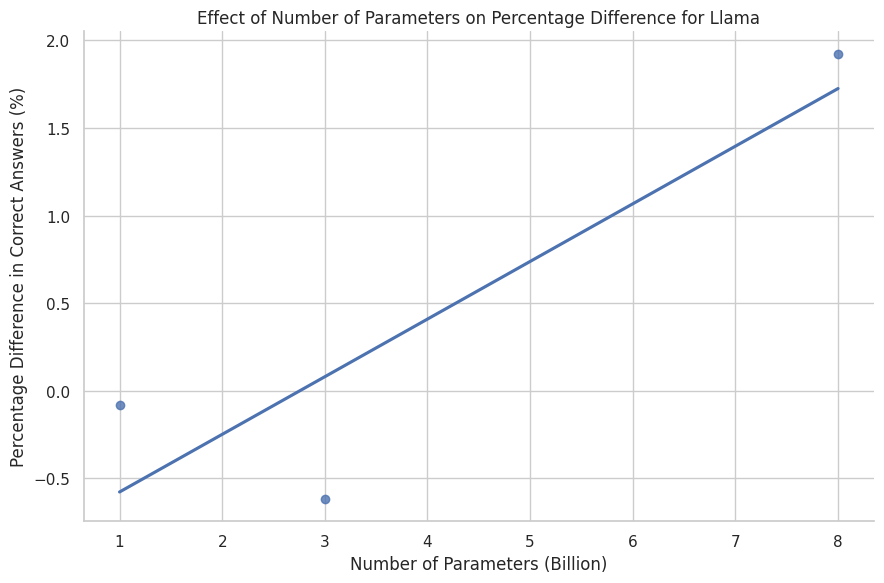

<Figure size 1000x600 with 0 Axes>

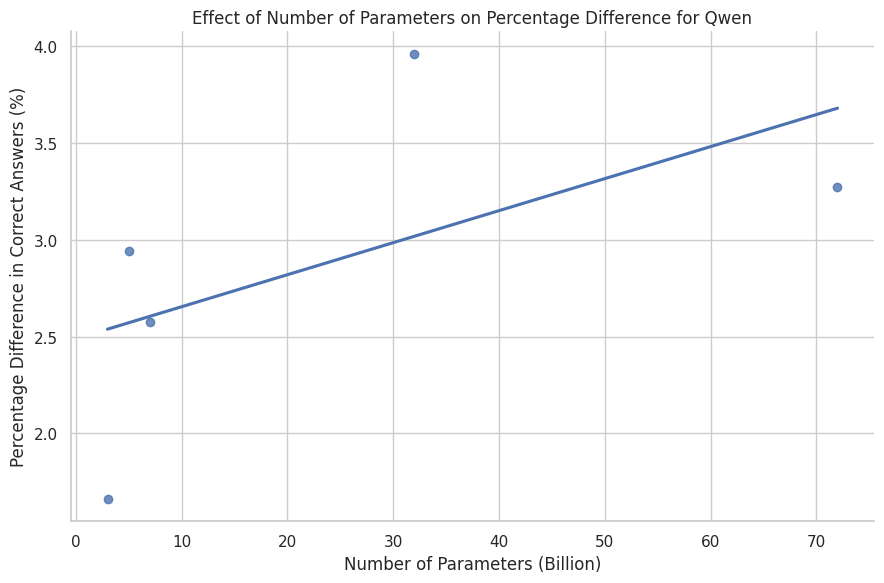

<Figure size 1000x600 with 0 Axes>

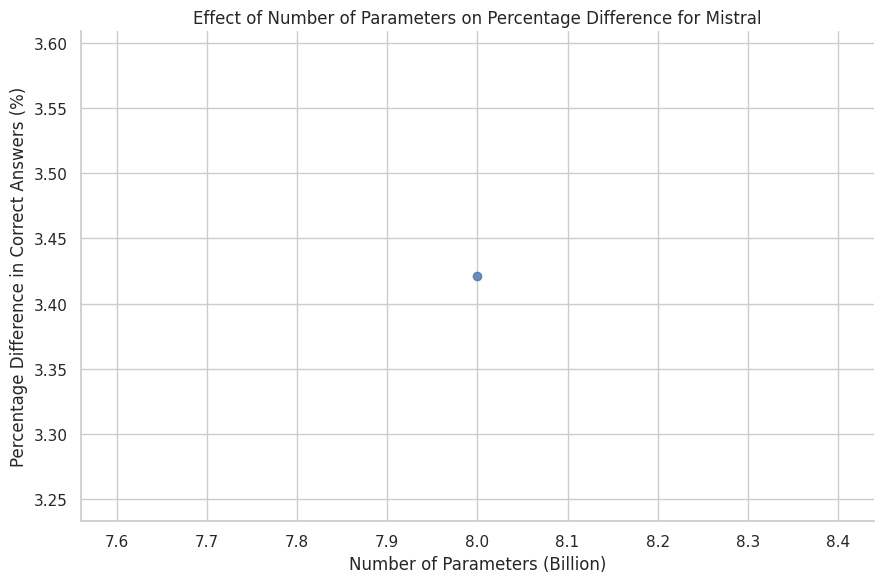

<Figure size 1000x600 with 0 Axes>

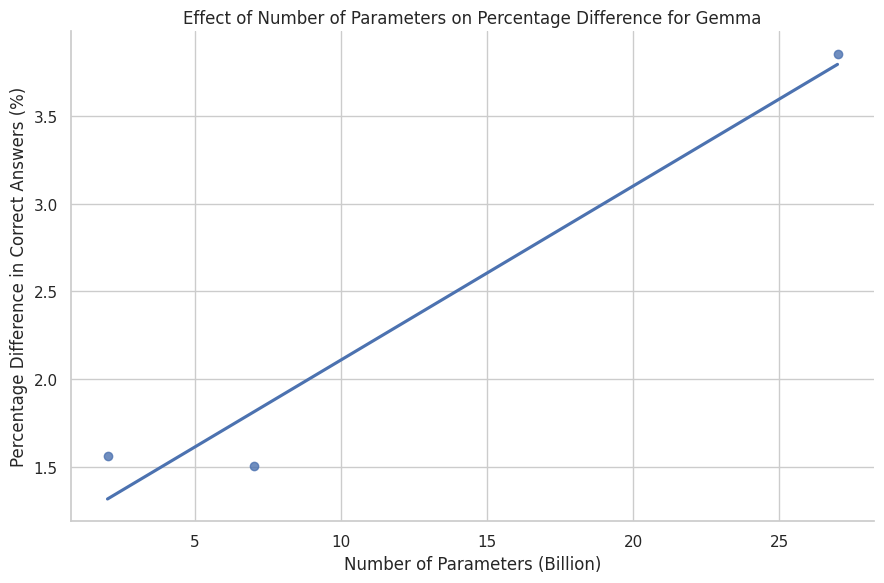

<Figure size 1000x600 with 0 Axes>

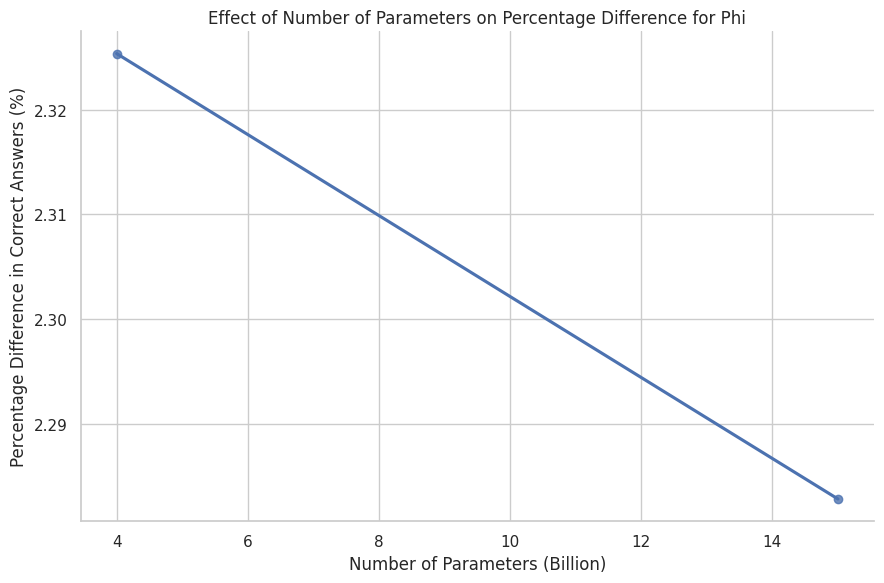

<Figure size 1000x600 with 0 Axes>

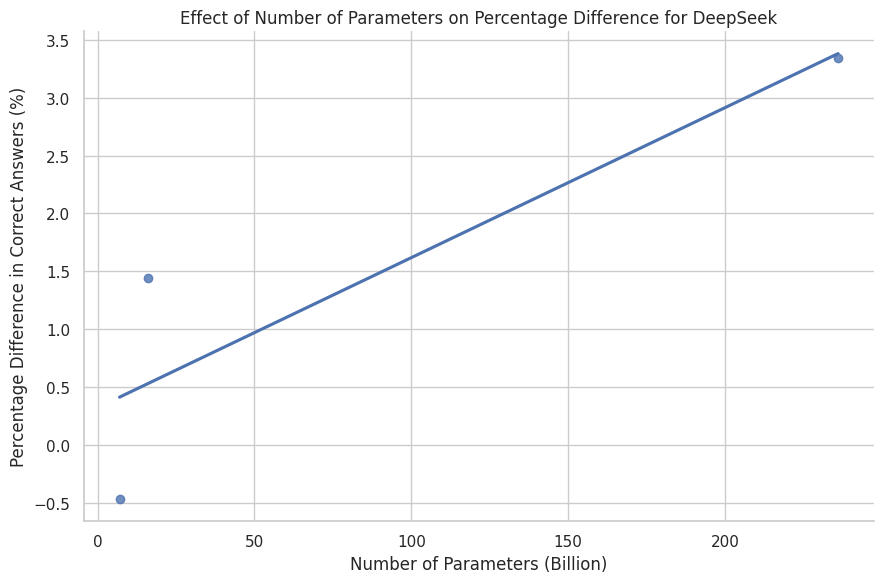

<Figure size 1000x600 with 0 Axes>

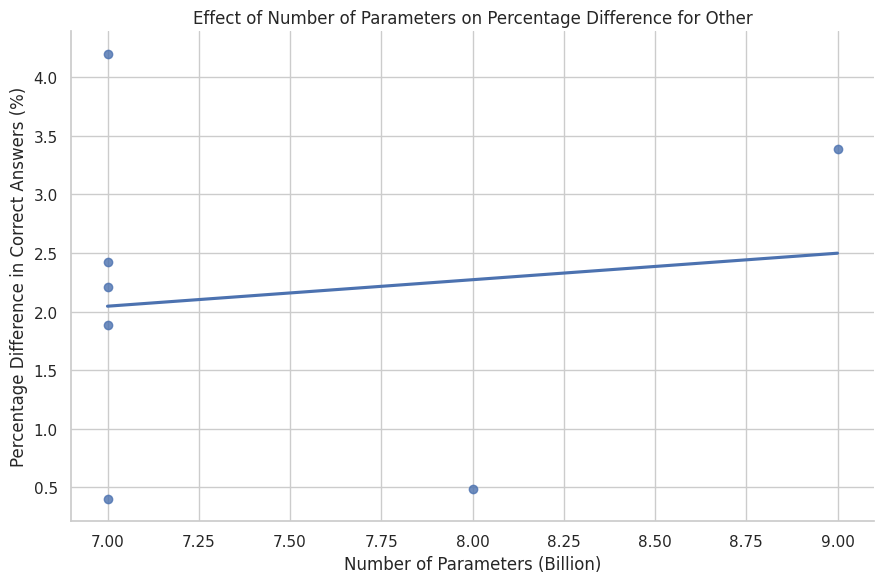

<Figure size 1000x600 with 0 Axes>

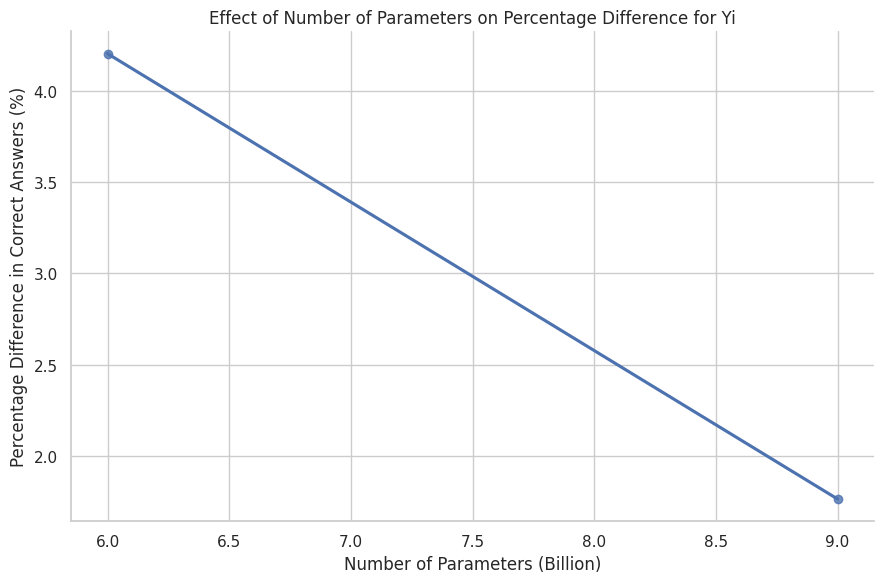

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for the plots
sns.set(style="whitegrid")

# Create a plot for each model family
families = results_df['Model Family'].unique()

for family in families:
    plt.figure(figsize=(10, 6))
    family_data = results_df[results_df['Model Family'] == family]
    sns.lmplot(x='Number of Params (Billion)', y='Percentage Diff (%)', data=family_data,
               aspect=1.5, height=6, markers='o', ci=None, palette='muted')
    plt.title(f'Effect of Number of Parameters on Percentage Difference for {family}')
    plt.xlabel('Number of Parameters (Billion)')
    plt.ylabel('Percentage Difference in Correct Answers (%)')
    plt.tight_layout()
    plt.show()

In [ ]:
import pandas as pd
import os
import json

# Define the directory containing the JSON files
directory = r'C:\Users\seffi\OneDrive\Public\Documents\PostDoc\EvalMMLU'

# Initialize a dictionary to store the aggregated results by model and subject
model_subject_diff = {}

# Iterate over each result file in the directory
for filename in os.listdir(directory):
    if filename.startswith('results_') and filename.endswith('.json'):
        file_path = os.path.join(directory, filename)
        with open(file_path, 'r') as file:
            data = json.load(file)
            # Extract the model name from the filename
            model_name = filename.split('results_')[1].split('.json')[0]
            for entry in data:
                subject = entry.get('subject', 'Unknown')
                original_correct = entry.get('original_question_is_correct', False)
                rephrased_correct = entry.get('rephrased_question_is_correct', False)
                direct_diff = original_correct - rephrased_correct
                key = (model_name, subject)
                if key not in model_subject_diff:
                    model_subject_diff[key] = {'Direct Diff': 0, 'Count': 0}
                model_subject_diff[key]['Direct Diff'] += direct_diff
                model_subject_diff[key]['Count'] += 1

# Convert the aggregated results to a DataFrame
model_subject_diff_df = pd.DataFrame.from_dict(model_subject_diff, orient='index').reset_index()
model_subject_diff_df[['Model Name', 'Subject']] = pd.DataFrame(model_subject_diff_df['index'].tolist(), index=model_subject_diff_df.index)
model_subject_diff_df.drop(columns='index', inplace=True)

# Display the aggregated results
model_subject_diff_df

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\seffi\\OneDrive\\Public\\Documents\\PostDoc\\EvalMMLU'

In [ ]:
import pandas as pd
import os
import json

# Define the directory containing the JSON files
directory = r'C:\Users\seffi\OneDrive\Public\Documents\PostDoc\EvalMMLU'

# Initialize a dictionary to store the aggregated results by subject
subject_diff = {}

# Iterate over each result file in the directory
for filename in os.listdir(directory):
    if filename.startswith('results_') and filename.endswith('.json'):
        file_path = os.path.join(directory, filename)
        with open(file_path, 'r') as file:
            data = json.load(file)
            for entry in data:
                subject = entry.get('subject', 'Unknown')
                original_correct = entry.get('original_question_is_correct', False)
                rephrased_correct = entry.get('rephrased_question_is_correct', False)
                direct_diff = original_correct - rephrased_correct
                if subject not in subject_diff:
                    subject_diff[subject] = {'Direct Diff': 0, 'Count': 0}
                subject_diff[subject]['Direct Diff'] += direct_diff
                subject_diff[subject]['Count'] += 1

# Convert the aggregated results to a DataFrame
subject_diff_df = pd.DataFrame.from_dict(subject_diff, orient='index').reset_index()
subject_diff_df.rename(columns={'index': 'Subject'}, inplace=True)

# Display the aggregated results
subject_diff_df